In [1]:
from models.mnist_classifier.lenet import LeNet5, LeNet1
import torch
import torchvision
from torchvision.datasets.mnist import MNIST
from torchvision.datasets import FashionMNIST
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchcam.methods import GradCAMpp
import torchvision.models as models
import numpy as np
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
from torchvision.utils import save_image
import os
import captum
from captum.attr import IntegratedGradients, Occlusion, LayerGradCam, LayerAttribution
from captum.attr import visualization as viz
import math
import random
from scipy.spatial import distance

os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

device = "cuda:0" if torch.cuda.is_available() else "cpu"
# 数据集预览什么的，记得看下tensorboard

In [2]:
net = torchvision.models.resnet18(pretrained=False)
# net = LeNet1()
# net.load_state_dict(torch.load('models/mnist_classifier/weights/lenet_epoch=12_test_acc=0.991.pth'))
net_dir = 'autodl-tmp/save_model/fashion/resnet18/resnet_epoch=2_test_acc=0.853.pth'
net.load_state_dict(torch.load(net_dir))
net.eval()
# net = net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [3]:
# 将数据集转换为PyTorch张量，并将像素值标准化为范围在0到1之间
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.repeat(3,1,1)),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))])
data_root = './autodl-tmp/fashion-mnist'
trainset = FashionMNIST(root=data_root, train=True, download=False, transform=transform)
testset = FashionMNIST(root=data_root, train=False, download=False, transform=transform)
len(testset)

10000

In [4]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=256,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(testset, batch_size=256,
                                         shuffle=False, num_workers=0)

In [5]:
# 计算热力图标准差
def StandardDeviation(map):  # map为热力图
    n = len(map) ** 2
    h_average = sum(sum(map)) / n
    total = 0
    for hi in map:
        for hj in hi:
            total += (hj - h_average) ** 2  
    total /= n
    return math.sqrt(total)

In [5]:
# 计算热力图熵
def entropy(map):
    n = len(map) ** 2
    dic = {}
    for pi in map:
        for pj in pi:
            pj = round(pj,3)
            if pj not in dic.keys():
                dic[pj] = 1
            else:
                dic[pj] += 1
    total = 0
    tmp = map.copy()
    for i in range(len(tmp)):
        for j in range(len(tmp[0])):
            tmp[i][j] = dic[round(tmp[i][j],3)] / n
            total += tmp[i][j] * math.log(tmp[i][j])
    return -total

In [6]:
# 设置阈值，计算热力图高于阈值的百分比
def percentile(map, threshold):
    n = len(map) ** 2
    total = 0
    for pi in map:
        for pj in pi:
            if pj < threshold:
                total += 1
    return total / n * 100

In [6]:
# gradcam
layers = list(net.modules())

In [7]:
cam = LayerGradCam(net, layer=layers[64]) # lenet1是5，lenet5是5（倒数第二层卷积层），resnet18是64

In [16]:
layers

[ResNet(
   (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
   (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   (relu): ReLU(inplace=True)
   (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
   (layer1): Sequential(
     (0): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU(inplace=True)
       (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     )
     (1): BasicBlock(
       (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
       (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
       (relu): ReLU

In [8]:
X, Y = iter(testloader).next()  # X为图像，Y为标签，一共10000张。
# X, Y = X.to(device), Y.to(device)
Y_logits = net(X)
Y_probs = F.softmax(Y_logits, dim=-1)
Y_preds = Y_probs.argmax(axis=-1)

In [ ]:
# 改batch的问题，只测了一个batch

In [9]:
len(X)

256

In [10]:
# 计算预训练模型acc
preds = net(X).cpu().detach().numpy()
class_preds = np.argmax(preds, axis=1)
print(class_preds)
print('test acc', np.sum(class_preds == Y.numpy()) / 256)

[9 2 1 1 6 1 4 6 8 7 4 5 7 3 4 1 2 6 8 0 4 7 7 5 1 6 6 6 9 6 8 8 1 3 8 0 7
 7 7 9 6 1 6 9 4 7 2 1 6 6 4 4 5 8 2 2 8 4 8 0 7 7 8 5 1 1 6 4 7 8 7 0 2 6
 2 3 1 2 8 4 1 8 5 9 5 0 3 2 0 6 5 3 6 7 1 8 0 1 4 2 3 6 7 6 7 8 5 9 9 4 2
 5 7 0 5 2 8 4 7 8 0 0 9 9 3 0 8 4 1 5 4 1 9 1 8 4 6 1 2 5 1 6 0 0 1 6 1 1
 2 6 3 4 1 3 5 0 4 7 9 3 7 2 3 9 0 9 4 7 4 2 6 5 4 1 2 1 3 6 9 1 0 9 3 6 7
 9 9 4 4 7 1 2 1 6 3 2 8 3 6 1 1 0 2 9 2 4 0 7 9 8 4 1 8 4 1 3 1 4 7 2 8 5
 4 0 7 7 6 6 7 6 7 8 9 2 9 0 5 1 4 4 5 4 9 2 2 8 6 4 6 2 9 7 6 5 5 4]
test acc 0.8515625


In [13]:
sd = {}  # StandardDeviation list
for i in range(len(X)):
    feature_imp_img = cam.attribute(X[i].unsqueeze(0), target=Y[i].unsqueeze(0))  # .unsqueeze(0)增加一个维度
    # saliency_map = LayerAttribution.interpolate(feature_imp_img, (32, 32))
    saliency_map = LayerAttribution.interpolate(feature_imp_img, (224, 224))  # lenet1的input size是28*28
    saliency_map = saliency_map[0][0].detach().cpu().numpy()   
    if i not in sd.keys():
        sd[i] = StandardDeviation(saliency_map)  # 注意取绝对值
sd = sorted(sd.items(), key=lambda s:s[1])

In [14]:
saliency_map.shape

(224, 224)

In [15]:
SEED_NUM = 1000  # 选择xxx个种子
seeds_idx, seeds_label = [], []
lab_count = [0 for _ in range(10)]  # 记录每个标签选了多少个种子，标签与序号对应；暂定每个标签选一样的个数
for (i,_) in sd:
    if lab_count[int(Y[i])] < SEED_NUM // 10:
        seeds_idx.append(i)
        seeds_label.append(int(Y[i]))
        lab_count[int(Y[i])] += 1
    if sum(lab_count) == SEED_NUM:
        break

In [16]:
seeds = []
for i in seeds_idx:
    seeds.append(X[i])

In [17]:
len(seeds_label)

256

In [18]:
def display_img(imgs, height, width):
    fig = plt.figure(figsize=(10, 10))
    for i in range(len(imgs)):
        ax = fig.add_subplot(height, width, i + 1, xticks=[], yticks=[])  # 5行6列，坐标为空
        plt.subplots_adjust(left=None,bottom=None,right=None,top=None,wspace=0.15,hspace=0.15)  # 无缝布局，间距可改
        orig_image = imgs[i].numpy().transpose(1, 2, 0)  # 交换通道
        std = [0.5, 0.5, 0.5]
        mean = [0.5, 0.5, 0.5]
        orig_image = orig_image * std + mean
        plt.imshow(orig_image)
    plt.show()

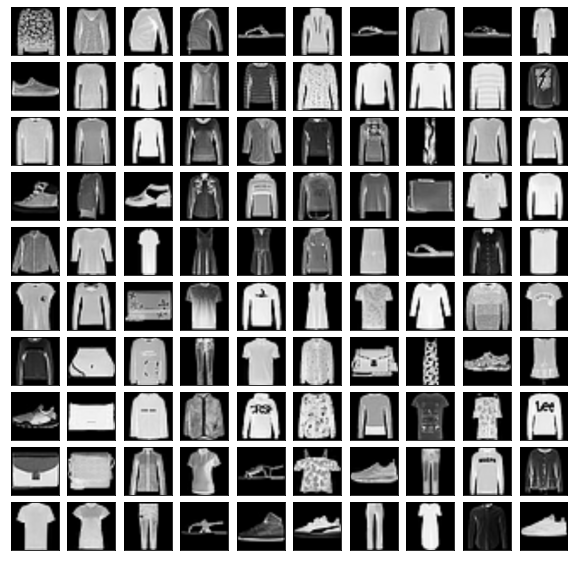

In [19]:
display_img(seeds[:100], 10, 10)

In [16]:
# 目前还差：②除了fgsm外的其他攻击方式

In [18]:
def compute_prob(g):
    pmin, a = 0.5, 20  # pmin=0.5, γ=20
    if g < (1 - pmin) * a:
        return 1 - g / a
    else:
        return pmin

In [19]:
def add_advblock(x_tmp, x_grad, heat_topk, k, width):
    i = heat_topk[k] // width
    j = heat_topk[k] % width
    x_tmp[0][0][i][j] = x_grad[0][0][i][j]
    return x_tmp

In [20]:
def visualize(x, x_adv, x_grad, epsilon, clean_pred, adv_pred, clean_prob, adv_prob):
    std = [0.5, 0.5, 0.5]
    mean = [0.5, 0.5, 0.5]
    x = x.squeeze(0)     #remove batch dimension # B X C H X W ==> C X H X W
    x = x.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op- "unnormalize"
    x = np.transpose(x, (1,2,0))   # C X H X W  ==>   H X W X C
    x = np.clip(x, 0, 1)
    
    x_adv = x_adv.squeeze(0)
    x_adv = x_adv.mul(torch.FloatTensor(std).view(3,1,1)).add(torch.FloatTensor(mean).view(3,1,1)).numpy()#reverse of normalization op
    x_adv = np.transpose(x_adv, (1,2,0))   # C X H X W  ==>   H X W X C
    x_adv = np.clip(x_adv, 0, 1)
    
    x_grad = x_grad.squeeze(0).numpy()
    x_grad = np.transpose(x_grad, (1,2,0))
    x_grad = np.clip(x_grad, 0, 1)
    
    figure, ax = plt.subplots(1,3, figsize=(18,8))
    ax[0].imshow(x)
    ax[0].set_title('Clean Example', fontsize=20)
    
    
    ax[1].imshow(x_grad)
    ax[1].set_title('Perturbation', fontsize=20)
    ax[1].set_yticklabels([])
    ax[1].set_xticklabels([])
    ax[1].set_xticks([])
    ax[1].set_yticks([])

    
    ax[2].imshow(x_adv)
    ax[2].set_title('Adversarial Example', fontsize=20)
    
    ax[0].axis('off')
    ax[2].axis('off')

    ax[0].text(1.1,0.5, "+{}*".format(round(epsilon,3)), size=15, ha="center", 
             transform=ax[0].transAxes)
    
    ax[0].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(clean_pred, clean_prob), size=15, ha="center", 
         transform=ax[0].transAxes)
    
    ax[1].text(1.1,0.5, " = ", size=15, ha="center", transform=ax[1].transAxes)

    ax[2].text(0.5,-0.13, "Prediction: {}\n Probability: {}".format(adv_pred, adv_prob), size=15, ha="center", 
         transform=ax[2].transAxes)
    

    plt.show()

In [21]:
# 预测单张图
def pred_one_pic(im):
    img_tensor = Variable(torch.unsqueeze(im, dim=0).float(), requires_grad=False)
    output = torch.softmax(net(img_tensor),dim=1)
    pred_val, pred_idx = torch.max(output, 1)
    return float(pred_val[0]), int(pred_idx[0])  # 概率，标签

In [22]:
# seeds、模糊次数g、prob、正确label 放一个字典里
seeds_info = {}  # 例如{1: seed1, g, p, 7}
for i in range(len(seeds)):
    seeds_info[i] = [seeds[i], 0, 1, seeds_label[i]]
# print(seeds_info)

In [24]:
# 写大循环
TOTAL = 10000  # 总的生成测试用例数量，设置为和初始test集一样大
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
# k = 32*32
k = 28*28
eps = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
save_step = 200  # 每x步保存一次种子
count_save_tests = 0  # 计数生成了多少个测试用例

while count_save_tests < TOTAL:
    # 开始选择
    seeds_prob = [seeds_info[key][2] for key in seeds_info]
    chosen_seed_idx = random.choices(list(seeds_info.keys()), seeds_prob)[0]
    print(f'选择种子序号：{chosen_seed_idx}')
    # 选中后更新g和p
    seeds_info[chosen_seed_idx][1] += 1
    seeds_info[chosen_seed_idx][2] = compute_prob(seeds_info[chosen_seed_idx][1])
    print(f'更新该种子被选择次数和概率：{seeds_info[chosen_seed_idx][1:]}')
    chosen_seed = seeds_info[chosen_seed_idx][0]  # 原始种子
    chosen_label = seeds_info[chosen_seed_idx][3]  # 原始种子标签
    x_pred_prob = pred_one_pic(chosen_seed)[0]   # 原始种子预测概率
    x_pred_prob = float(x_pred_prob * 100)  
    # 开始处理
    feature_imp_img = cam.attribute(chosen_seed.unsqueeze(0), target=torch.from_numpy(np.array(chosen_label)).unsqueeze(0))  # .unsqueeze(0)增加一个维度
    # saliency_map = LayerAttribution.interpolate(feature_imp_img, (32, 32))
    saliency_map = LayerAttribution.interpolate(feature_imp_img, (28, 28))

    heat_topk = torch.topk(saliency_map[0][0].flatten(), k).indices  # topk热力值的索引位置（将整个32x32拉通了）
    heat_topk = heat_topk.tolist()
    
    img_tensor = torch.unsqueeze(chosen_seed, dim=0).float()  # 这一段和pred_one_pic有点重复，后续看看怎么删减一下
    img_variable = Variable(img_tensor, requires_grad=True)
    output = net.forward(img_variable)
    label_idx = int(torch.max(output.data, 1)[1][0])   #get an index(class number) of a largest element
    x_pred = labels[label_idx]
    
    # FGSM
    y_true = label_idx
    target = Variable(torch.LongTensor([chosen_label]), requires_grad=False)
    loss = torch.nn.CrossEntropyLoss()
    loss_cal = loss(output, target)
    loss_cal.backward(retain_graph=True)
    
    x_grad = torch.sign(img_variable.grad.data)  #calculate the sign of gradient of the loss func (with respect to input X) (adv)
    # x_tmp = torch.zeros(1, 1, 32, 32)
    x_tmp = torch.zeros(1, 1, 28, 28)
    
    # 开始扰动处理，只保留选中方框内的梯度值
    count_new_seed = 0
    e = random.choice(eps)
    print(f'选择eps：{e}')
    for i in range(len(heat_topk)):
        # x_tmp = add_advblock(x_tmp, x_grad, heat_topk, i, 32)
        x_tmp = add_advblock(x_tmp, x_grad, heat_topk, i, 28)
        x_adversarial = img_variable.data + e * x_tmp
        x_adv_pred = pred_one_pic(x_adversarial[0])[1]
        
        if x_adv_pred != chosen_label:
            # 保存x_adversarial，文件夹名是正确标签
            # save_image(x_adversarial[0], 'testcases/test/'+str(chosen_label)+'/'+str(count_save_tests)+'.png')
            # 为了后面重训练，先直接保存为tensor了，如果要论文截图再存图片
            torch.save(x_adversarial[0].to(torch.device('cpu')), 'autodl-tmp/testcases/fashion/lenet1/'+str(chosen_label)+'/'+str(count_save_tests)+'.pth')
            count_save_tests += 1
            # l2 = distance.euclidean(x_adversarial[0][0], img_tensor[0][0])  # 暂时不知道怎么写，x_adversarial[0][0]和img_tensor[0][0]都是2d的，这个函数需要1d
            print(f'成功生成1个测试用例，目前累计生成{count_save_tests}个测试用例')
            break
        elif i == 0: continue
        elif i % save_step == 0 or i == len(heat_topk) - 1:
            seeds_info[len(seeds_info)] = [x_adversarial[0], 0, 1.0, x_pred]
            count_new_seed += 1
    print(f'该种子共循环{i}次，产生{count_new_seed}个新种子')
    print('---------------------------------')
print('生成结束')

选择种子序号：557
更新该种子被选择次数和概率：[1, 0.95, 6]
选择eps：0.4
成功生成1个测试用例，目前累计生成1个测试用例
该种子共循环0次，产生0个新种子
---------------------------------
选择种子序号：517
更新该种子被选择次数和概率：[1, 0.95, 9]
选择eps：0.05
该种子共循环783次，产生4个新种子
---------------------------------
选择种子序号：196
更新该种子被选择次数和概率：[1, 0.95, 0]
选择eps：0.6
成功生成1个测试用例，目前累计生成2个测试用例
该种子共循环130次，产生0个新种子
---------------------------------
选择种子序号：719
更新该种子被选择次数和概率：[1, 0.95, 5]
选择eps：0.8
成功生成1个测试用例，目前累计生成3个测试用例
该种子共循环243次，产生1个新种子
---------------------------------
选择种子序号：619
更新该种子被选择次数和概率：[1, 0.95, 6]
选择eps：0.5
成功生成1个测试用例，目前累计生成4个测试用例
该种子共循环30次，产生0个新种子
---------------------------------
选择种子序号：333
更新该种子被选择次数和概率：[1, 0.95, 9]
选择eps：0.2
该种子共循环783次，产生4个新种子
---------------------------------
选择种子序号：214
更新该种子被选择次数和概率：[1, 0.95, 0]
选择eps：0.6
成功生成1个测试用例，目前累计生成5个测试用例
该种子共循环82次，产生0个新种子
---------------------------------
选择种子序号：292
更新该种子被选择次数和概率：[1, 0.95, 7]
选择eps：0.01
该种子共循环783次，产生4个新种子
---------------------------------
选择种子序号：848
更新该种子被选择次数和概率：[1, 0.95, 8]
选择eps：0.5
成功生成1个测试用例，目前累计生成6个测试用例
该种

In [25]:
x_adversarial[0].shape

torch.Size([1, 32, 32])

In [ ]:
pred_one_pic(x_adversarial[0])

In [ ]:
x_adversarial[0]

In [ ]:
input_image[0]

In [ ]:
normalized_tensor

In [ ]:
torch.save(x_adversarial[0].to(torch.device('cpu')), "myTensor.pth")
 
y = torch.load("myTensor.pth")
print(y)

In [ ]:
save_image(x_adversarial[0], 'testcases/test.png')

In [ ]:
# 加载示例图像并进行预处理
preprocess = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Resize((32, 32))])
image_path = 'output_image.png'
image = Image.open(image_path)
input_image = preprocess(image)
input_image = input_image.unsqueeze(0)  # 添加批次维度


In [ ]:
pred_one_pic(input_image[0])

In [ ]:
# 开始选择
seeds_prob = [seeds_info[key][2] for key in seeds_info]
chosen_seed_idx = random.choices(list(seeds_info.keys()), seeds_prob)[0]
print(chosen_seed_idx)

In [ ]:
# 选中后更新g和p
seeds_info[chosen_seed_idx][1] += 1
seeds_info[chosen_seed_idx][2] = compute_prob(seeds_info[chosen_seed_idx][1])
print(seeds_info[chosen_seed_idx])

In [ ]:
chosen_seed = seeds_info[chosen_seed_idx][0]

In [ ]:
tmp = chosen_seed.numpy().transpose(1, 2, 0) 
std = [0.5, 0.5, 0.5]
mean = [0.5, 0.5, 0.5]
tmp = tmp * std + mean
plt.imshow(tmp)
plt.show()

In [ ]:
pred_one_pic(chosen_seed)[0]   # 原始种子预测概率和预测结果


In [ ]:
# 现在把处理过程迁移过来：
feature_imp_img = cam.attribute(chosen_seed.unsqueeze(0), target=Y[i].unsqueeze(0))  # .unsqueeze(0)增加一个维度
saliency_map = LayerAttribution.interpolate(feature_imp_img, (32, 32))
print(torch.abs(saliency_map))

In [ ]:
k = 32*32
heat_topk = torch.topk(torch.abs(saliency_map)[0][0].flatten(), k).indices  # topk热力值的索引位置（将整个32x32拉通了）
heat_topk = heat_topk.tolist()

In [ ]:
saliency_map = saliency_map[0][0].detach().cpu().numpy()
np.argmax(saliency_map)
plt.imshow(saliency_map)
plt.show()

In [ ]:
img_tensor = torch.unsqueeze(chosen_seed, dim=0).float()
img_variable = Variable(img_tensor, requires_grad=True)
output = net.forward(img_variable)
label_idx = int(torch.max(output.data, 1)[1][0])   #get an index(class number) of a largest element
print(label_idx)
labels = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
x_pred = labels[label_idx]
print(x_pred)

In [ ]:
print(torch.max(output, 1))

In [ ]:
# FGSM
y_true = label_idx
target = Variable(torch.LongTensor([y_true]), requires_grad=False)
print(target)
loss = torch.nn.CrossEntropyLoss()
loss_cal = loss(output, target)
loss_cal.backward(retain_graph=True)

In [ ]:
eps = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
x_grad = torch.sign(img_variable.grad.data)                #calculate the sign of gradient of the loss func (with respect to input X) (adv)
x_tmp = torch.zeros(1, 1, 32, 32)

In [ ]:
# 处理，只保留选中方框内的梯度值
save_step = 50  # 每x步保存一次种子
for i in range(len(heat_topk)):
    x_tmp = add_advblock(x_tmp, x_grad, heat_topk, i, 32)
    x_adversarial = img_variable.data + eps[9] * x_tmp
    output_adv = net.forward(Variable(x_adversarial))
    x_adv_pred = labels[int(torch.max(output_adv.data, 1)[1][0])]
    if x_adv_pred != x_pred:
        break
    elif i % save_step == 0 or i == len(heat_topk) - 1:
        seeds_info[len(seeds_info)] = [x_adversarial[0], 0, 1.0]
print(i)

In [ ]:
seeds_info.keys()

In [ ]:
x_adv_pred = labels[int(torch.max(output_adv.data, 1)[1][0])]
print(x_adv_pred)

In [ ]:
op_adv_probs = F.softmax(output_adv, dim=1)                 #get probability distribution over classes
adv_pred_prob = float((torch.max(op_adv_probs.data, 1)[0][0]) * 100)      #find probability (confidence) of a predicted class
print(adv_pred_prob)

In [ ]:
visualize(img_tensor, x_adversarial, x_tmp, eps[9], x_pred, x_adv_pred, x_pred_prob, adv_pred_prob)

In [ ]:
x_adversarial

In [ ]:
save_image(x_adversarial, 'try.png')